In [1]:
import sys
sys.path.append('../scripts/')
from read_utils import read_file, create_folder, temp_record_query, temp_record_sdf

In [2]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

In [3]:
spark = (
    # Create a spark session (which will run spark jobs)
    SparkSession.builder.appName("Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config('spark.executor.memory','10g')
    .config('spark.driver.memory','12g')
    .config('spark.driver.maxResultsSize', '10GiB')
    # .config("spark.network.timeout", "3600s")
    # .master("local[6]")
    .getOrCreate()
    )

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/10 02:17:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/10 02:17:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
trans_sdf = read_file(spark, 'changed_data', '../data/curated/')

|> Loading File...


|> Loading Finished!


-RECORD 0-------------------------------------------------------------------------------------------
 user_id         | 9521                                                                             
 merchant_abn    | 10023283211                                                                      
 dollar_value    | 86.95574860858353                                                                
 order_id        | c6c473f9-e796-4c1c-b952-4df1c93f3b4a                                             
 tags            | furniture, home furnishings and equipment shops, and manufacturers, except ap... 
 take_rate       | 0.18                                                                             
 type            | e                                                                                
 postcode        | 4753                                                                             
 consumer_id     | 838133                                                                  

In [5]:
consumer_fraud_sdf = read_file(spark,'consumer_fraud_probability.csv', '../data/tables/', 'csv')

|> Loading File...
|> Loading Finished!
-RECORD 0-----------------------------
 user_id           | 6228             
 order_datetime    | 2021-12-19       
 fraud_probability | 97.6298077657765 
only showing top 1 row



In [6]:
sdf = trans_sdf.select( 'user_id', 'merchant_abn', 'order_datetime', 'dollar_value', 'take_rate', 'consumer_id', 'POA_CODE21', 'longitude', 'latitude', 'genderIndex', 'typeIndex', 'tagIndex', 'tag_vec', 'New cases / day', 'total_retail')

### Feature Attributes

In [7]:
import pyspark.sql.functions as F

In [8]:
sdf_daily = sdf.groupby('user_id', 'consumer_id', 'order_datetime', 'genderIndex', 'POA_CODE21', 'longitude', 'latitude', 'New cases / day', 'total_retail').agg(
    F.count("*").alias("count"), 
    F.min("dollar_value").alias("dollar_min"),
    F.max("dollar_value").alias("dollar_max"),
    F.avg("dollar_value").alias("dollar_average"),
    )

In [9]:
sdf_daily = sdf_daily.join(consumer_fraud_sdf, on=['user_id', 'order_datetime'], how = 'left')

In [10]:
sdf_daily.limit(5)

user_id,order_datetime,consumer_id,genderIndex,POA_CODE21,longitude,latitude,New cases / day,total_retail,count,dollar_min,dollar_max,dollar_average,fraud_probability
14993,2021-11-26,622472,2.0,2209,-33.94722917193708,151.07699782229673,1621.0,33345.0,5,22.453979561362384,734.8638440136032,186.3462312513625,null
4983,2021-11-26,1247943,1.0,5090,-34.84534419067749,138.6960323962213,1621.0,33345.0,2,5.283358090797645,26.04414295094381,15.663750520870728,null
16607,2021-11-26,1269252,0.0,2000,-33.8683837718929,151.2082196508253,1621.0,33345.0,1,37.17568711624101,37.17568711624101,37.17568711624101,null
10019,2021-11-26,364882,0.0,3161,-37.87203498863193,145.0215927557217,1621.0,33345.0,8,10.9995054244287,515.9291867859123,181.19076503328841,null
12354,2021-11-26,897226,0.0,6017,-31.91080499083522,115.81257121552099,1621.0,33345.0,5,5.701246534572349,79.32250775219197,31.445202658964785,null


In [11]:
sdf_daily.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- genderIndex: double (nullable = true)
 |-- POA_CODE21: long (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- New cases / day: double (nullable = true)
 |-- total_retail: double (nullable = true)
 |-- count: long (nullable = false)
 |-- dollar_min: double (nullable = true)
 |-- dollar_max: double (nullable = true)
 |-- dollar_average: double (nullable = true)
 |-- fraud_probability: string (nullable = true)



In [12]:
from pyspark.sql.functions import year, month, dayofmonth
sdf_daily = (sdf_daily
               .withColumn('order_year', year(sdf_daily.order_datetime))
               .withColumn('order_month', month(sdf_daily.order_datetime))
               .withColumn('order_day', dayofmonth(sdf_daily.order_datetime))
               )
# sdf_daily = sdf_daily.drop('order_datetime')
sdf_daily = sdf_daily\
    .withColumn('user_id', sdf_daily['user_id'].cast('int'))\
    .withColumn('POA_CODE21', sdf_daily['POA_CODE21'].cast('int'))\
    .withColumn('count', sdf_daily['count'].cast('int'))

In [13]:
sdf_daily.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- genderIndex: double (nullable = true)
 |-- POA_CODE21: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- New cases / day: double (nullable = true)
 |-- total_retail: double (nullable = true)
 |-- count: integer (nullable = false)
 |-- dollar_min: double (nullable = true)
 |-- dollar_max: double (nullable = true)
 |-- dollar_average: double (nullable = true)
 |-- fraud_probability: string (nullable = true)
 |-- order_year: integer (nullable = true)
 |-- order_month: integer (nullable = true)
 |-- order_day: integer (nullable = true)



In [14]:
train_data = sdf_daily.filter(sdf_daily.fraud_probability.isNotNull())

In [15]:
trans_data = sdf_daily.filter(sdf_daily.fraud_probability.isNull())

In [16]:
train_data.count()

34847

In [17]:
trans_data.count()

7959163

In [18]:
train_data = train_data.withColumn('fraud_probability', trans_data['fraud_probability'].cast('double'))

- Test Data

In [19]:
trans_data = trans_data.drop('fraud_probability')

### Model

In [20]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [21]:
input_col = ['genderIndex', 'longitude', 'latitude', 'New cases / day', 'dollar_min', 'dollar_max', 'dollar_average']

In [22]:
vecAssembler = VectorAssembler(inputCols=input_col, outputCol="features")

In [23]:
train_dataset = vecAssembler.transform(train_data)

In [24]:
test_dataset = vecAssembler.transform(trans_data)

In [25]:
train_dataset = train_dataset.withColumnRenamed('fraud_probability', 'label')

### Decision Tree Regressor Model

In [26]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator


# Using a decision tree model
dt = DecisionTreeRegressor(featuresCol="features")


model = dt.fit(train_dataset)

# Predictions
dfpredictions = model.transform(train_dataset)
dfpredictions.select("prediction", "label", "features").show(5)

# Evaluation
evaluator = RegressionEvaluator(
    labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(dfpredictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+------------------+------------------+--------------------+
|        prediction|             label|            features|
+------------------+------------------+--------------------+
| 9.611722331189984| 9.470053906287776|[0.0,-27.65835247...|
|13.693952436173232|11.561397859331406|[1.0,-33.69983128...|
| 58.71483693268185| 55.38576122239443|[1.0,-34.29501076...|
|13.693952436173232|12.130326216131659|[0.0,-23.65252545...|
| 9.611722331189984| 9.843249123612404|[1.0,-32.56361195...|
+------------------+------------------+--------------------+
only showing top 5 rows



Root Mean Squared Error (RMSE) on test data = 2.9888


In [27]:
test_dt_prediction = model.transform(test_dataset)
test_dt_prediction = test_dt_prediction.withColumnRenamed('prediction', 'fraud_probability')

In [28]:
test_dt_prediction.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- order_datetime: date (nullable = true)
 |-- consumer_id: string (nullable = true)
 |-- genderIndex: double (nullable = true)
 |-- POA_CODE21: integer (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- New cases / day: double (nullable = true)
 |-- total_retail: double (nullable = true)
 |-- count: integer (nullable = false)
 |-- dollar_min: double (nullable = true)
 |-- dollar_max: double (nullable = true)
 |-- dollar_average: double (nullable = true)
 |-- order_year: integer (nullable = true)
 |-- order_month: integer (nullable = true)
 |-- order_day: integer (nullable = true)
 |-- features: vector (nullable = true)
 |-- fraud_probability: double (nullable = false)



In [29]:
test_dt_prediction.agg(
    F.mean('fraud_probability'), 
    F.max('fraud_probability'),
    F.min('fraud_probability'), 
).show()

+----------------------+----------------------+----------------------+
|avg(fraud_probability)|max(fraud_probability)|min(fraud_probability)|
+----------------------+----------------------+----------------------+
|     9.639268229931165|      86.4467170975513|     9.611722331189984|
+----------------------+----------------------+----------------------+



In [30]:
test_dt_prediction.limit(5)

user_id,order_datetime,consumer_id,genderIndex,POA_CODE21,longitude,latitude,New cases / day,total_retail,count,dollar_min,dollar_max,dollar_average,order_year,order_month,order_day,features,fraud_probability
14993,2021-11-26,622472,2.0,2209,-33.94722917193708,151.07699782229673,1621.0,33345.0,5,22.453979561362384,734.8638440136032,186.3462312513625,2021,11,26,"[2.0,-33.94722917...",9.611722331189984
4983,2021-11-26,1247943,1.0,5090,-34.84534419067749,138.6960323962213,1621.0,33345.0,2,5.283358090797645,26.04414295094381,15.663750520870728,2021,11,26,"[1.0,-34.84534419...",9.611722331189984
16607,2021-11-26,1269252,0.0,2000,-33.8683837718929,151.2082196508253,1621.0,33345.0,1,37.17568711624101,37.17568711624101,37.17568711624101,2021,11,26,"[0.0,-33.86838377...",9.611722331189984
10019,2021-11-26,364882,0.0,3161,-37.87203498863193,145.0215927557217,1621.0,33345.0,8,10.9995054244287,515.9291867859123,181.19076503328841,2021,11,26,"[0.0,-37.87203498...",9.611722331189984
12354,2021-11-26,897226,0.0,6017,-31.91080499083522,115.81257121552099,1621.0,33345.0,5,5.701246534572349,79.32250775219197,31.445202658964785,2021,11,26,"[0.0,-31.91080499...",9.611722331189984


In [31]:
final_train = train_dataset.select('user_id', 'order_datetime', 'consumer_id', 'label').withColumnRenamed('label', 'fraud_probability')

In [32]:
final_test = test_dt_prediction.select('user_id', 'order_datetime', 'consumer_id', 'fraud_probability')

In [33]:
dt = final_train.union(final_test)

In [34]:
dt.write.parquet('../data/curated/consumer_fraud.parquet', mode = 'overwrite')

### LinearRegression Model

In [35]:
lr = LinearRegression(featuresCol='features',labelCol='label', maxIter=5, solver="normal")
lr_model=lr.fit(train_dataset)

22/10/10 02:20:17 WARN Instrumentation: [3ec662b3] regParam is zero, which might cause numerical instability and overfitting.


22/10/10 02:20:20 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/10 02:20:20 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


22/10/10 02:20:23 WARN InstanceBuilder$NativeLAPACK: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


In [36]:
print("Correlation coefficient:{}".format(lr_model.coefficients))
print("Intercept:{}".format(lr_model.intercept))

Correlation coefficient:[0.021997732613668965,-0.005250309009626391,0.0016573142188864196,1.1067761157139646e-05,0.0007501775465176127,0.0021256277410369776,-0.0008253403424790087]
Intercept:5.8430702450925205


In [37]:
training_predictions=lr_model.evaluate(train_dataset) 

In [38]:
print('{}{}'.format('Mean Square Error:',training_predictions.meanSquaredError))
print('{}{}'.format('R2 determination factor：',training_predictions.r2 ))

Mean Square Error:17.541948639623783
R2 determination factor：0.8227084142731159


In [39]:
test_pred = lr_model.transform(test_dataset)

In [40]:
test_pred = test_pred.withColumnRenamed('prediction', 'fraud_probability')

In [41]:
test_pred.limit(5)

user_id,order_datetime,consumer_id,genderIndex,POA_CODE21,longitude,latitude,New cases / day,total_retail,count,dollar_min,dollar_max,dollar_average,order_year,order_month,order_day,features,fraud_probability
14993,2021-11-26,622472,2.0,2209,-33.94722917193708,151.07699782229673,1621.0,33345.0,5,22.453979561362384,734.8638440136032,186.3462312513625,2021,11,26,"[2.0,-33.94722917...",7.758714432663033
4983,2021-11-26,1247943,1.0,5090,-34.84534419067749,138.6960323962213,1621.0,33345.0,2,5.283358090797645,26.04414295094381,15.663750520870728,2021,11,26,"[1.0,-34.84534419...",6.342216233821735
16607,2021-11-26,1269252,0.0,2000,-33.8683837718929,151.2082196508253,1621.0,33345.0,1,37.17568711624101,37.17568711624101,37.17568711624101,2021,11,26,"[0.0,-33.86838377...",6.365657542068061
10019,2021-11-26,364882,0.0,3161,-37.87203498863193,145.0215927557217,1621.0,33345.0,8,10.9995054244287,515.9291867859123,181.19076503328841,2021,11,26,"[0.0,-37.87203498...",7.255578245929938
12354,2021-11-26,897226,0.0,6017,-31.91080499083522,115.81257121552099,1621.0,33345.0,5,5.701246534572349,79.32250775219197,31.445202658964785,2021,11,26,"[0.0,-31.91080499...",6.3674245696495415


In [42]:
test_pred.select('fraud_probability')

fraud_probability
7.758714432663033
6.342216233821735
6.365657542068061
7.255578245929938
6.3674245696495415
6.7705113377315005
6.836088439721448
7.455525161362248
6.535935613548806
6.405522740722919


In [43]:
test_pred.count()

7959163

### GLM Model

In [44]:
train_dataset = train_dataset.withColumnRenamed('fraud_probability', 'label')

In [45]:
from pyspark.ml.regression import GeneralizedLinearRegression

In [46]:
glr = GeneralizedLinearRegression(family="gaussian", link="identity", maxIter=10, regParam=0.3)
 
# Fit the model
model = glr.fit(train_dataset)
 
# Print the coefficients and intercept for generalized linear regression model
print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))
 
# Summarize the model over the training set and print out some metrics
summary = model.summary
print("Coefficient Standard Errors: " + str(summary.coefficientStandardErrors))
print("T Values: " + str(summary.tValues))
print("P Values: " + str(summary.pValues))
print("Dispersion: " + str(summary.dispersion))
print("Null Deviance: " + str(summary.nullDeviance))
print("Residual Degree Of Freedom Null: " + str(summary.residualDegreeOfFreedomNull))
print("Deviance: " + str(summary.deviance))
print("Residual Degree Of Freedom: " + str(summary.residualDegreeOfFreedom))
print("AIC: " + str(summary.aic))
print("Deviance Residuals: ")
summary.residuals().show()


Coefficients: [0.017619630300594165,-0.004472710396098588,0.0018468931291952134,9.205389225784135e-06,0.0001097181449143927,0.001586507869052845,0.0003256662144254651]
Intercept: 6.102847890926335


Coefficient Standard Errors: [0.03410070048926688, 0.004377047736712928, 0.0018850303786179605, 9.442815064174082e-07, 1.5718555496215173e-05, 1.1087044920614936e-05, 2.410117440544271e-05, 0.29352150810217414]
T Values: [0.5166940868601777, -1.0218555211503133, 0.9797683634941162, 9.7485645575219, 6.980167162358616, 143.0956472542956, 13.51246246124507, 20.791825206900846]
P Values: [0.6053730042514716, 0.3068563822197543, 0.32720727525975324, 0.0, 3.000932835561798e-12, 0.0, 0.0, 0.0]
Dispersion: 18.052428911282714


Null Deviance: 3447903.5298756245
Residual Degree Of Freedom Null: 34846
Deviance: 628928.5708401785
Residual Degree Of Freedom: 34839


AIC: 199723.6377884563
Deviance Residuals: 


+--------------------+
|   devianceResiduals|
+--------------------+
| -0.8280493244630538|
|  -2.274944921944053|
|    9.41385565149045|
|  -0.806954883099861|
|-0.03382959960305...|
|  2.7946523984377194|
| -1.0688919876199119|
| -1.7372564641151662|
|  4.0620931735075985|
|   4.552410235500767|
|  1.4431068252040173|
|  0.9569138567227213|
|  1.0062264430851364|
|  1.1212889326088664|
|  2.9882680264033787|
|   6.160532514788217|
| -2.5922089874087604|
| -1.6024501699967697|
| -0.8499655892940812|
|  0.6194654593431181|
+--------------------+
only showing top 20 rows



In [47]:
train_glr_pred = model.transform(train_dataset)

In [48]:
test_glr_pred = model.transform(test_dataset)

In [49]:
test_glr_pred = test_glr_pred.withColumnRenamed('prediction', 'fraud_probability')

### Feature correlation and covariance

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
train_corr = train_data.toPandas()

In [51]:
columns = train_data.columns
corr = train_corr[columns].corr(method='spearman')

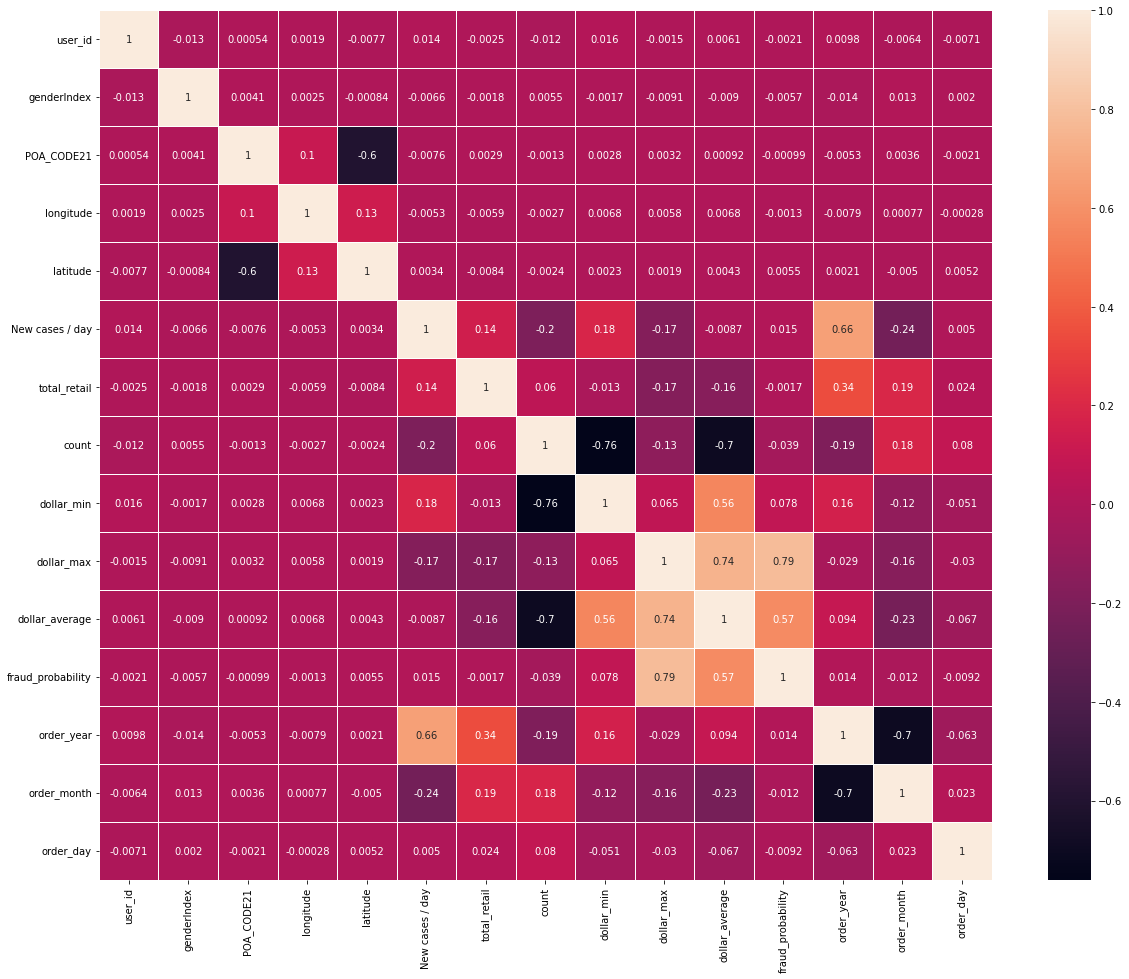

In [52]:
fig = plt.figure(figsize=(20,16))
sns.heatmap(corr,annot = True, linewidths=1)
plt.show()

In [53]:
from pyspark.ml.feature import VectorAssembler

In [54]:
input_col = columns[3:]

In [55]:
vecAssembler = VectorAssembler(inputCols=input_col, outputCol="features")

In [56]:
trans_data.dtypes

[('user_id', 'int'),
 ('order_datetime', 'date'),
 ('consumer_id', 'string'),
 ('genderIndex', 'double'),
 ('POA_CODE21', 'int'),
 ('longitude', 'double'),
 ('latitude', 'double'),
 ('New cases / day', 'double'),
 ('total_retail', 'double'),
 ('count', 'int'),
 ('dollar_min', 'double'),
 ('dollar_max', 'double'),
 ('dollar_average', 'double'),
 ('order_year', 'int'),
 ('order_month', 'int'),
 ('order_day', 'int')]

In [57]:
train_dataset = vecAssembler.transform(train_data)

In [58]:
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
r1 = Correlation.corr(train_dataset, "features")
r1_head = r1.head()

print(r1)
print("Pearson correlation matrix:\n" + str(r1_head[0]))
print("-------------------------------------------------------------------------")

r2 = Correlation.corr(train_dataset, "features", "spearman")
r2_head = r2.head()
print("Spearman correlation matrix:\n" + str(r2_head[0]))


+--------------------+
|   pearson(features)|
+--------------------+
|1.0              ...|
+--------------------+

Pearson correlation matrix:
DenseMatrix([[ 1.00000000e+00,  2.07241573e-03,  1.82860749e-03,
               3.82342623e-04, -7.36016869e-03, -4.42051858e-03,
               2.38670453e-03, -6.88140227e-04, -5.67128132e-03,
              -3.68988693e-03, -3.78259691e-03, -1.37828169e-02,
               1.55238205e-02,  1.37192795e-03],
             [ 2.07241573e-03,  1.00000000e+00,  7.85907912e-03,
              -6.63162502e-01, -3.19585110e-03,  2.28204520e-03,
              -3.38749752e-03,  5.33385416e-03,  3.49917462e-05,
               4.15453878e-03, -2.22305125e-03, -4.79097759e-03,
               4.48625924e-03, -3.10924822e-03],
             [ 1.82860749e-03,  7.85907912e-03,  1.00000000e+00,
              -1.05180465e-01, -5.09766802e-03, -5.71754837e-03,
               3.49397780e-04,  3.32154861e-03,  4.09727731e-03,
               3.73925239e-03,  9.66413929e

Spearman correlation matrix:
DenseMatrix([[ 1.00000000e+00,  4.10337709e-03,  2.47041461e-03,
              -8.43020597e-04, -6.62565617e-03, -1.82296992e-03,
               5.46831484e-03, -1.68501109e-03, -9.07481695e-03,
              -8.95201099e-03, -5.71355882e-03, -1.37692054e-02,
               1.27299606e-02,  2.01663716e-03],
             [ 4.10337709e-03,  1.00000000e+00,  1.00609860e-01,
              -6.03528165e-01, -7.56326227e-03,  2.91323195e-03,
              -1.31575344e-03,  2.84758483e-03,  3.22650969e-03,
               9.15332446e-04, -9.89362225e-04, -5.31104305e-03,
               3.59834933e-03, -2.05336277e-03],
             [ 2.47041461e-03,  1.00609860e-01,  1.00000000e+00,
               1.31535551e-01, -5.28949684e-03, -5.86153068e-03,
              -2.67175142e-03,  6.81506628e-03,  5.75633922e-03,
               6.81523294e-03, -1.27489840e-03, -7.90730807e-03,
               7.70365310e-04, -2.78931317e-04],
             [-8.43020597e-04, -6.03528165e-

In [60]:
dense_matrix = r1.to_pandas_on_spark().iloc[0][0]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyspark/sql/dataframe.py:3315: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  FutureWarning,


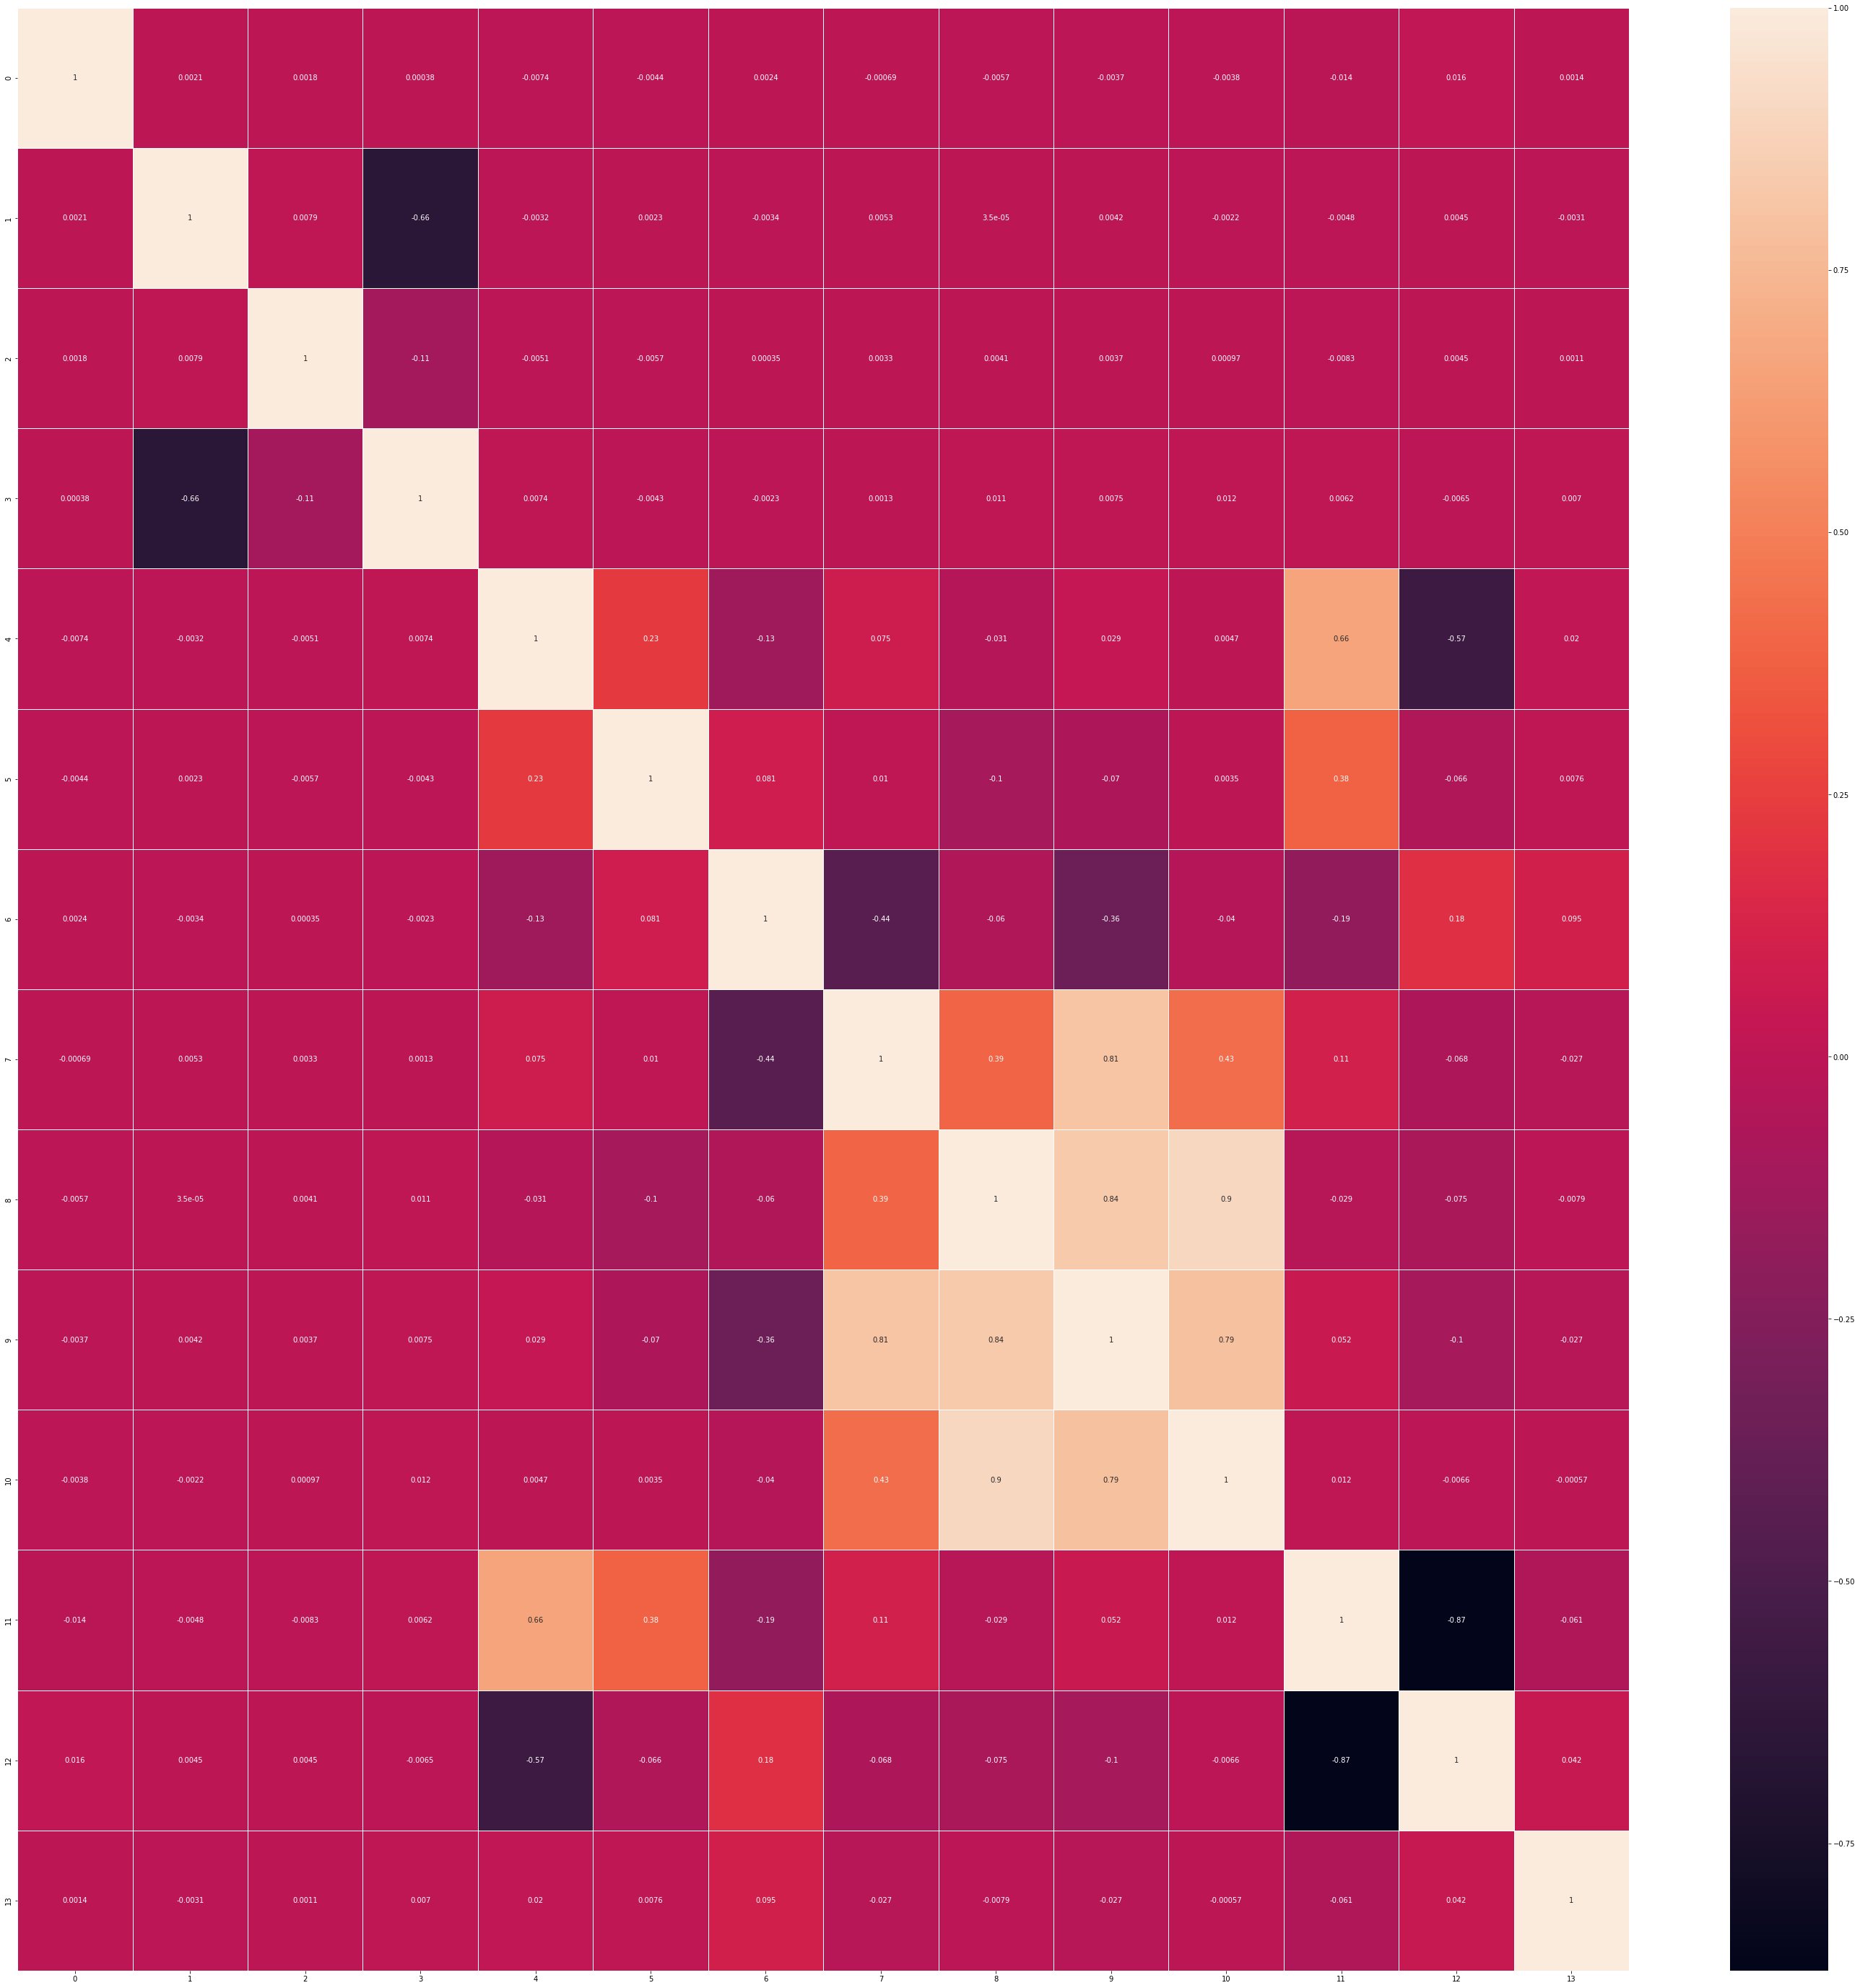

In [61]:
fig = plt.figure(figsize=(50,50))
sns.heatmap(dense_matrix.toArray(),annot = True, linewidths=1)
plt.show()

In [62]:
dense_matrix2 = r2.to_pandas_on_spark().iloc[0][0]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyspark/sql/dataframe.py:3315: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  FutureWarning,


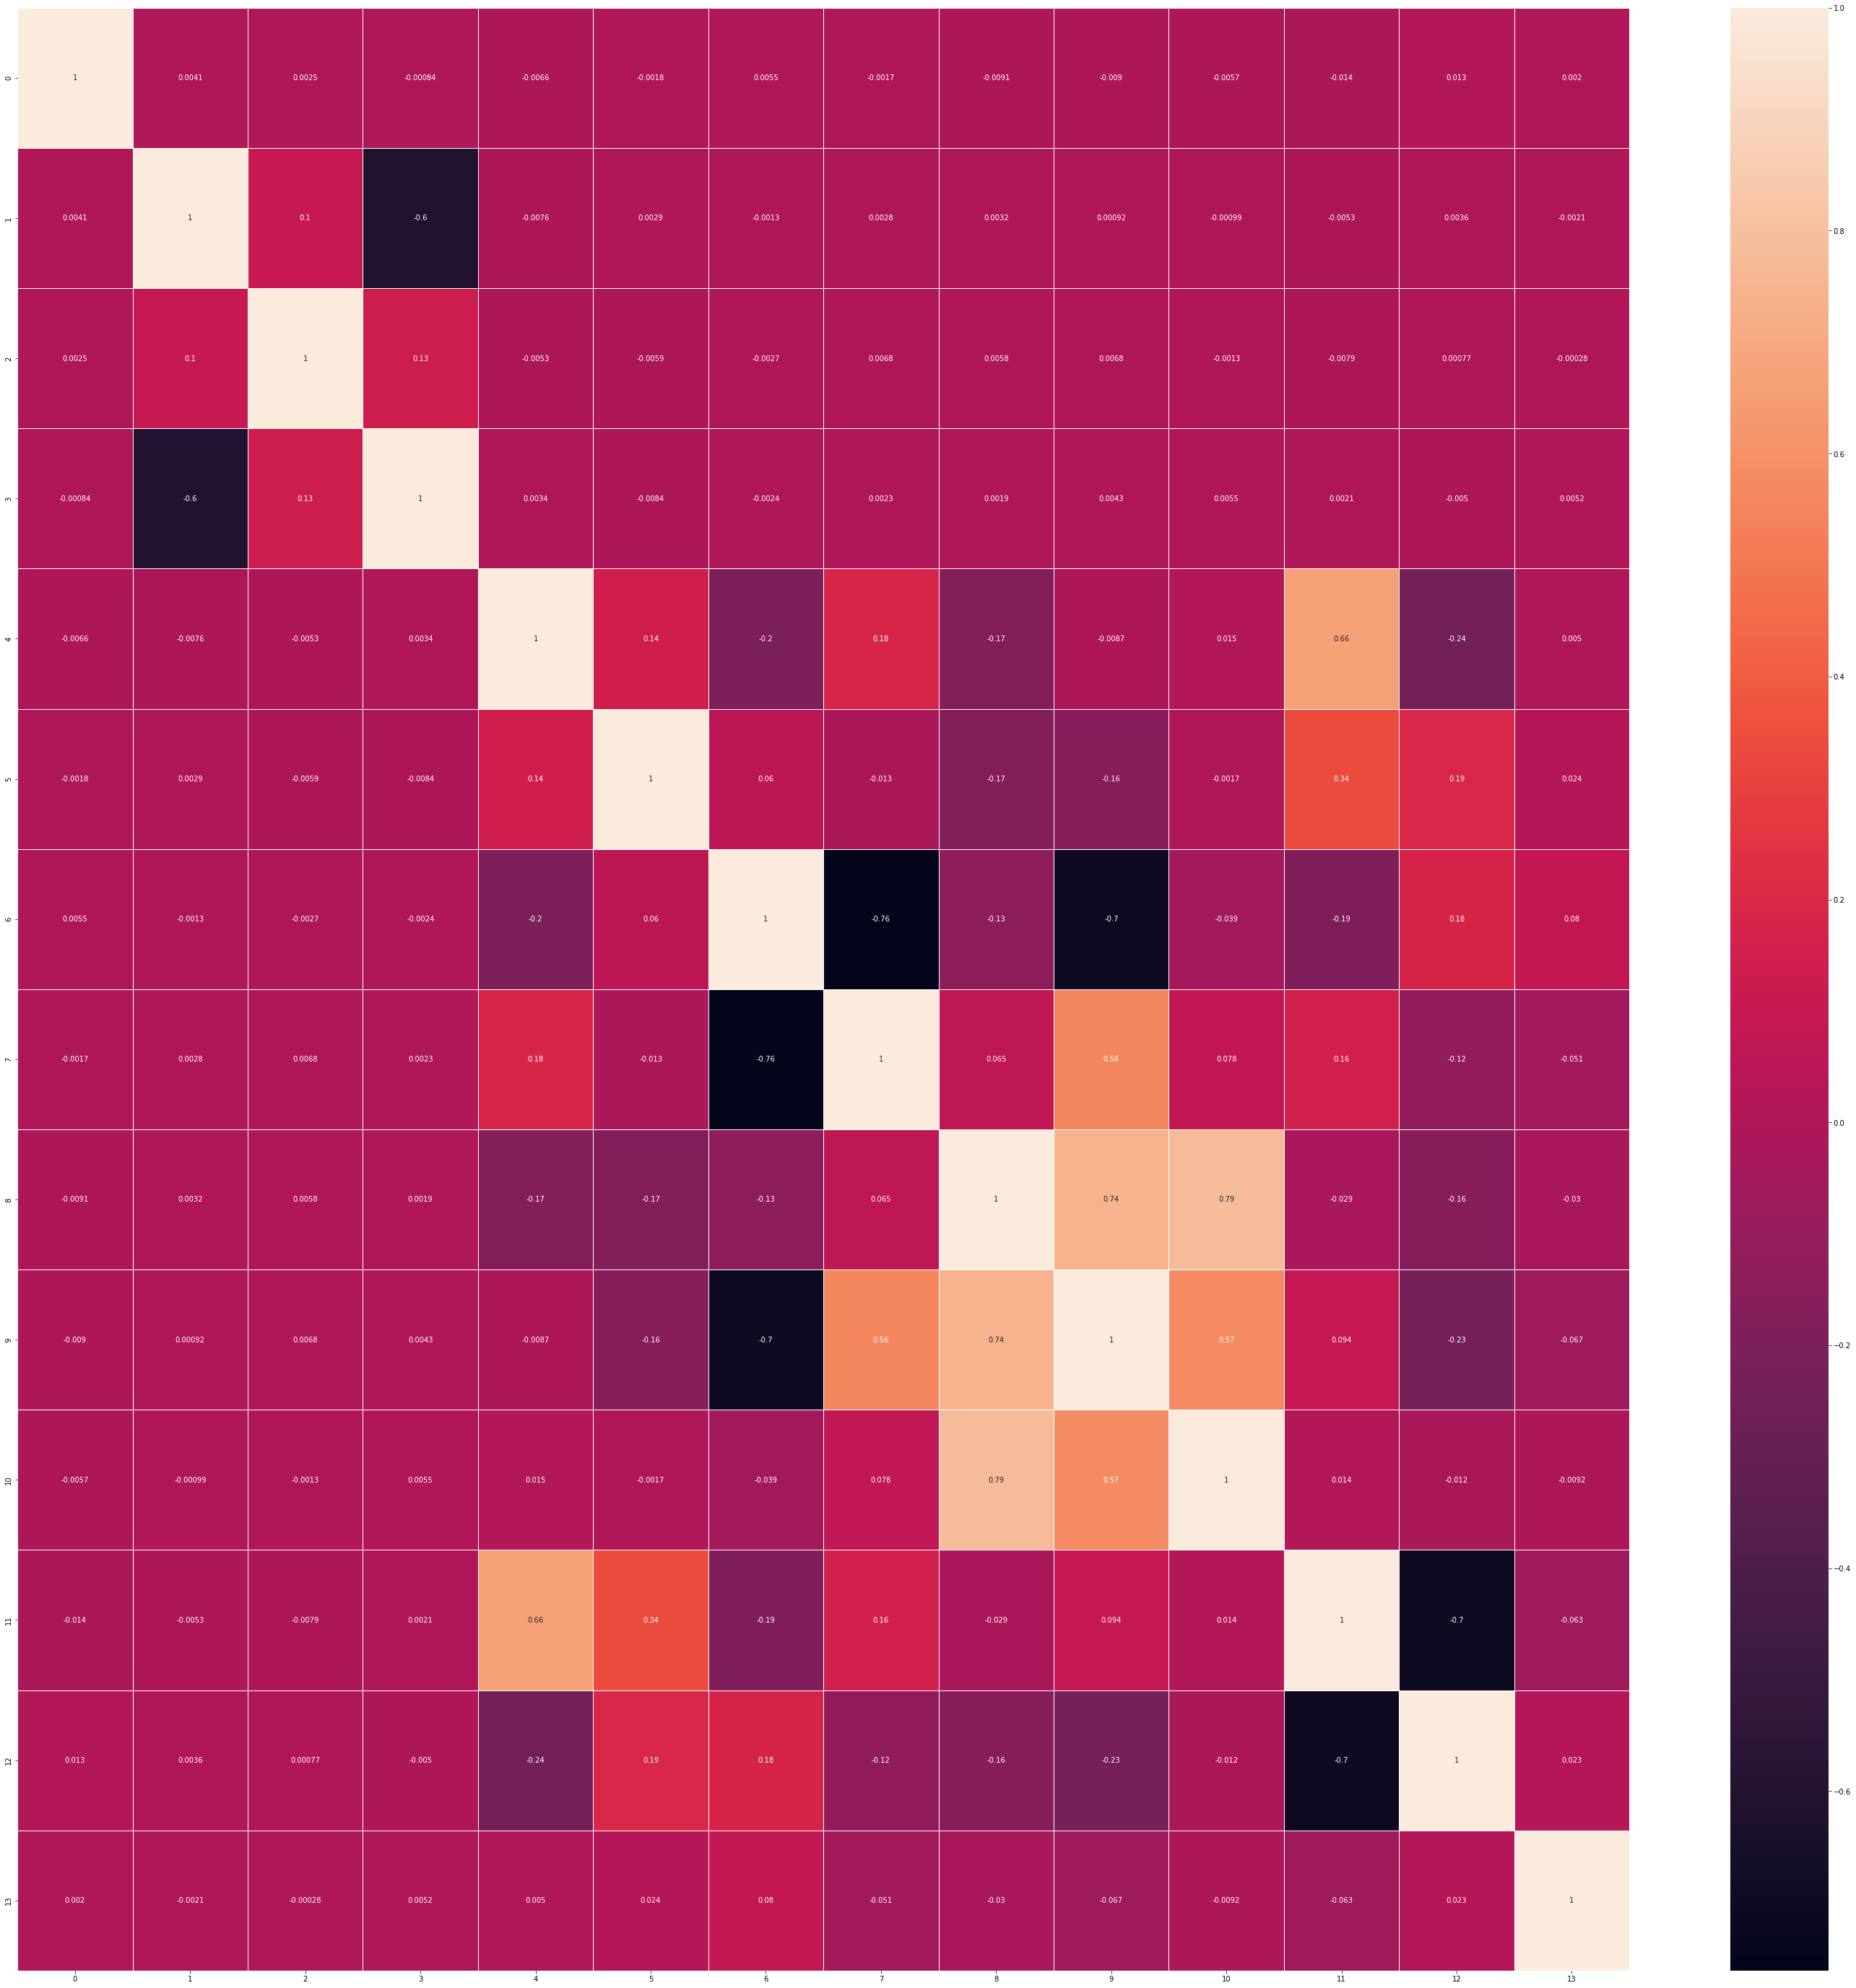

In [63]:
fig = plt.figure(figsize=(50,50))
sns.heatmap(dense_matrix2.toArray(),annot = True, linewidths=1)
plt.savefig('../plots/Feature_HeatMap.png')
plt.show()